# Investigating Causal Effect of Road Lighting on Severity of Traffic Accidents with Casualties – Causal Inference Final Project

### Import packages

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (
    mean_squared_error, pairwise_distances, pairwise_distances_argmin, 
    confusion_matrix, classification_report
                             )
from sklearn.calibration import calibration_curve
import scipy.stats as st

### Import the data

In [4]:
df = pd.read_csv('dataset.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12670 entries, 0 to 12669
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pk_teuna_fikt      12670 non-null  int64  
 1   sug_tik            12670 non-null  int64  
 2   THUM_GEOGRAFI      12670 non-null  int64  
 3   SUG_DEREH          12670 non-null  int64  
 4   SEMEL_YISHUV       12670 non-null  int64  
 5   REHOV1             8055 non-null   float64
 6   REHOV2             4197 non-null   float64
 7   BAYIT              4382 non-null   float64
 8   ZOMET_IRONI        4198 non-null   float64
 9   KVISH1             3853 non-null   float64
 10  KVISH2             3787 non-null   float64
 11  KM                 3848 non-null   float64
 12  ZOMET_LO_IRONI     1222 non-null   float64
 13  YEHIDA             12670 non-null  int64  
 14  SHNAT_TEUNA        12670 non-null  int64  
 15  HODESH_TEUNA       12670 non-null  int64  
 16  SHAA               126

### Data pre-processing

In [6]:
# columns to remove
cols_to_remove = ['sug_tik', 'SHNAT_TEUNA'] # , pk_teuna_fikt]
df.drop(columns=cols_to_remove, inplace=True)

# rows to remove:

# THUM_GEOGRAFI == 2  (remove rows of yehuda and shomron records)
df.drop(index=df[df['THUM_GEOGRAFI'] == 2].index, inplace=True)
# then drop whole column since all values are the same
df.drop(columns=['THUM_GEOGRAFI'], inplace=True)
# YOM_LAYLA  == 1 (use only night time records)
df.drop(index=df[df['YOM_LAYLA'] == 1].index, inplace=True)
# TEURA == 10 (don't use twilight records)
df.drop(index=df[df['TEURA'] == 10].index, inplace=True)
# rows with unknown coordinates
df.dropna(subset=['X', 'Y'], inplace=True)

In [7]:
df.shape

(3916, 42)

In [8]:
df['TEURA'].value_counts()

3    2680
6     925
5     187
4     112
7      12
Name: TEURA, dtype: int64

### Exploratory Data Analtsis

In [ ]:
grouped_df = df.groupby(['HUMRAT_TEUNA','MEHIRUT_MUTERET']).count().iloc[:,0].to_dict()

# HUMRAT_TEUNA, SUG_DEREH

# groups = list(grouped_df.groups.keys())
# labels = [str(group) for group in groups]

grouped_df

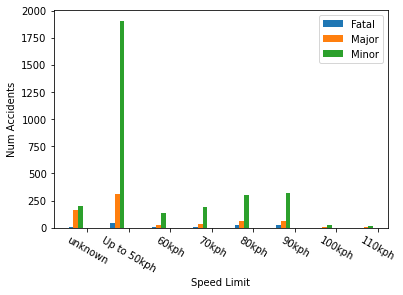

In [19]:
def plot_grouped_bar_chart(data_dict, x_label='', y_label='', title='',
                           category_labels=dict()):
    fig, ax = plt.subplots()    

    severity_level = {1: 'Fatal', 2:'Major', 3:'Minor'}
    

    # Extract the unique x-axis values
    x_values = sorted(set([key[0] for key in data_dict.keys()]))
    y_values = sorted(set([key[1] for key in data_dict.keys()]))

    # Determine the number of bars per group
    # num_bars_per_group = int(len(data_dict) / len(x_values))

    # Set the bar width and spacing
    bar_width = 0.9 / len(y_values)
    x_offsets = np.arange(len(x_values)) * bar_width

    # Iterate over the x-axis values and plot the bars
    for i, x_val in enumerate(x_values):
        # Extract the y-axis values for this x-axis value
        values = [data_dict[x_val, y_val] for y_val in y_values]

        # Calculate the x positions of the bars
        x_positions = np.arange(len(y_values)) + x_offsets[i]

        # Plot the bars for this x-axis value
        ax.bar(x_positions, values, width=bar_width, label=severity_level[x_val])

    # Add axis labels and legend
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(y_values)) + (len(y_values)-1)/2 * bar_width)
    plt.xticks(rotation=-30)
    ax.set_xticklabels([category_labels[i] for i in (y_values)])
    ax.legend()

    plt.show()


# severity_level = ['Fatal', 'Major', 'Minor']
road_type = {1:'City Itersection', 2:'City Road', 3:'Inter-City Intersection', 4:'Inter-City Road'}
day = {1: 'Sun', 2:'Mon', 3: 'Tue', 4:'Wed', 5:'Thu', 6:'Fri', 7:'Sat'}
width = {0: 'unknown', 1: 'Up to 5m', 2: '5 to 7m', 3: '7 to 10.5m', 4: '10.5 to 14m', 5: 'Over 14m'}
speed = {0: 'unknown', 1: 'Up to 50kph', 2: '60kph', 3: '70kph', 4: '80kph', 5:'90kph', 6:'100kph', 7:'110kph'}
plot_grouped_bar_chart(grouped_df, x_label='Speed Limit', y_label='Num Accidents',
                       title='', category_labels=speed)

### Deal with unknown night lighting ('TEURA' == 6)
Try to find rows from the same location with different lighting code

In [53]:
relevant_cols = ['SEMEL_YISHUV', 'REHOV1', 'REHOV2','BAYIT', 'ZOMET_IRONI', 
                 'KVISH1', 'KVISH2', 'KM', 'ZOMET_LO_IRONI', 'YEHIDA',
                 'HAD_MASLUL', 'RAV_MASLUL', 'MAHOZ', 'NAFA', 'EZOR_TIVI',
                 'MAAMAD_MINIZIPALI', 'ZURAT_ISHUV', 'STATUS_IGUN', 'X', 'Y']
# df_temp = df[relevant_cols]
unknown_light = df[df['TEURA'] == 6][relevant_cols + ['TEURA', 'pk_teuna_fikt']]
known_light = df[df['TEURA'] != 6][relevant_cols + ['TEURA', 'pk_teuna_fikt']]

joint = pd.merge(unknown_light, known_light, on=relevant_cols, how='inner')

for i, row in joint[joint['TEURA_y'] == 5].iterrows():
  original_row_index = df[df['pk_teuna_fikt'] == row['pk_teuna_fikt_x']].index
  df.loc[original_row_index, 'TEURA'] = 5

# remove all other 'unknown' lighting condition rows
df.drop(index=df[df['TEURA'] == 6].index, inplace=True)

There are about 60 rows of accidents in which the lighting conditions is unknown, but we may deduced it from rows of different accidents which accured on the same location where the lighting condition is not unknown. Having said that, we can only deduced this iformation with a high level of confidence from rows with a known lighting condition = 5 (among the 'known' rows), which means 'no lighting', since, if for example the lighting condition recorded for a row is 'improper lighting', we can not assume with high certainty that this was the condition on another accident happened on the same location (it may have been fixed since, or broke between the two accidents happened).

Remainig 'unknown' lighting condition rows were removed.

In [54]:
df['TEURA'].value_counts()

3    2680
5     195
4     112
7      12
Name: TEURA, dtype: int64

lighting condition code '7' means "proper lighting with limited visibility". This may refer to an object limiting the drivers field of vision (directly, or by blocking the light), e.g., a tree, fog, smoke, heavy rain, and can be considered as a hidden confounder: all these rows have 'weather' condition 'rainy' recorded, but we can't tell it affected the visibility for example. So these rows will be removed as well.

In [55]:
df.drop(index=df[df['TEURA'] == 7].index, inplace=True)

In [56]:
df.shape

(2987, 42)

In [57]:
df['TEURA'].value_counts()

3    2680
5     195
4     112
Name: TEURA, dtype: int64

### Replace column TEURA with T (for treatment) and values 0 or 1
0 == no lighting; 1 == proper lighting

In [12]:
df['T'] = df['TEURA'].apply(lambda x: 1 if x == 3 else 0)
df.drop(columns=['TEURA'], inplace=True)

### Naively check accidents severity distribution

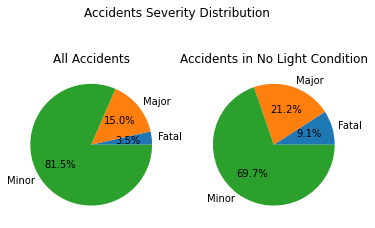

In [13]:
all_accidents = df['HUMRAT_TEUNA'].value_counts().to_dict()
no_light_accidents = df[df['T'] == 0]['HUMRAT_TEUNA'].value_counts().to_dict()

label = {1: 'Fatal', 2:'Major', 3:'Minor'}

fig, ax = plt.subplots(1, 2)
fig.suptitle("Accidents Severity Distribution")

ax[0].pie([all_accidents[i+1] for i in range(3)], labels=[label[i+1] for i in range(3)], autopct='%1.1f%%')
ax[1].pie([no_light_accidents[i+1] for i in range(3)], labels=[label[i+1] for i in range(3)], autopct='%1.1f%%')

ax[0].set_title("All Accidents")
ax[1].set_title("Accidents in No Light Condition")

plt.show()

In [14]:
# proportion of accidents recorded on intercity raods
df[df['SUG_DEREH'].isin([3,4])].shape[0] / df.shape[0]

0.3294275192500837

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2987 entries, 12 to 12669
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pk_teuna_fikt      2987 non-null   int64  
 1   SUG_DEREH          2987 non-null   int64  
 2   SEMEL_YISHUV       2987 non-null   int64  
 3   REHOV1             1848 non-null   float64
 4   REHOV2             1024 non-null   float64
 5   BAYIT              902 non-null    float64
 6   ZOMET_IRONI        1024 non-null   float64
 7   KVISH1             984 non-null    float64
 8   KVISH2             971 non-null    float64
 9   KM                 983 non-null    float64
 10  ZOMET_LO_IRONI     333 non-null    float64
 11  YEHIDA             2987 non-null   int64  
 12  HODESH_TEUNA       2987 non-null   int64  
 13  SHAA               2987 non-null   int64  
 14  SUG_YOM            2987 non-null   int64  
 15  YOM_LAYLA          2987 non-null   int64  
 16  YOM_BASHAVUA       298

### Deal with NaN cells
- 'REHOV1', 'REHOV2' - nan to '0'
- 'ZOMET_IRONI' - first drop rows with value < 10 (2 rows in daylight and minor severity), then nan to 0
- 'KM' - change negative values to positive (it's just some signal of unknown hundredth meter, then nan to 0
columns to drop:
- 'BAYIT' - most of the cells are NaN, most of not-nan are '9999' which is likely the same as 'unknown' - drop this column

In [16]:
df.drop(index=df[df['ZOMET_IRONI'] < 10].index, inplace=True)

df.drop(index=df[df['ZOMET_IRONI'] < 10].index, inplace=True)

for i in df[df['KM'] < 0].index:
  df.loc[i, 'KM'] = np.abs(df.loc[i, 'KM'])

to_drop = ['BAYIT', 'pk_teuna_fikt']
df.drop(columns=to_drop, inplace=True)

nan_to_0 = ['REHOV1', 'REHOV2', 'ZOMET_IRONI', 'KVISH1', 'KVISH2', 'KM', 'ZOMET_LO_IRONI']

df.fillna(0, inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2985 entries, 12 to 12669
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SUG_DEREH          2985 non-null   int64  
 1   SEMEL_YISHUV       2985 non-null   int64  
 2   REHOV1             2985 non-null   float64
 3   REHOV2             2985 non-null   float64
 4   ZOMET_IRONI        2985 non-null   float64
 5   KVISH1             2985 non-null   float64
 6   KVISH2             2985 non-null   float64
 7   KM                 2985 non-null   float64
 8   ZOMET_LO_IRONI     2985 non-null   float64
 9   YEHIDA             2985 non-null   int64  
 10  HODESH_TEUNA       2985 non-null   int64  
 11  SHAA               2985 non-null   int64  
 12  SUG_YOM            2985 non-null   int64  
 13  YOM_LAYLA          2985 non-null   int64  
 14  YOM_BASHAVUA       2985 non-null   int64  
 15  HUMRAT_TEUNA       2985 non-null   int64  
 16  SUG_TEUNA          298

# Compute Propensity Score

In [18]:
T = df['T']
Y = df['HUMRAT_TEUNA']
X = df.drop(['T', 'HUMRAT_TEUNA'], axis=1)

X_train, X_test, T_train, T_test = train_test_split(X, T, random_state=27)

In [19]:
# X_train.shape, X_test.shape
print(T_train.value_counts())
print(T_test.value_counts())

1    2004
0     234
Name: T, dtype: int64
1    674
0     73
Name: T, dtype: int64


### Try logistic-regression model

In [20]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train,T_train)
lr_model.score(X_train, T_train), lr_model.score(X_test, T_test), lr_model.score(X, T)
T_pred = lr_model.predict(X_test)
print(confusion_matrix(T_test, T_pred))
print(classification_report(T_test, T_pred))

[[  7  66]
 [  7 667]]
              precision    recall  f1-score   support

           0       0.50      0.10      0.16        73
           1       0.91      0.99      0.95       674

    accuracy                           0.90       747
   macro avg       0.70      0.54      0.55       747
weighted avg       0.87      0.90      0.87       747



### Try XGBoost

In [ ]:
xgb_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, max_features='sqrt')
xgb_model.fit(X_train, T_train)
xgb_model.score(X_train, T_train), xgb_model.score(X_test, T_test), xgb_model.score(X, T)

T_pred = xgb_model.predict(X_test)
print(confusion_matrix(T_test, T_pred))
print(classification_report(T_test, T_pred))
print("total conf_mat:")
print(confusion_matrix(T, xgb_model.predict(X)))
print("total accuracy: ", xgb_model.score(X, T))

### XGBoost adjusted for imbalanced data

In [ ]:
# format data for training
dtrain = xgb.DMatrix(X_train, label=T_train)
dtest = xgb.DMatrix(X_test, label=T_test)

# calculate scale_pos_weight
count_negatives = len(T_train) - sum(T_train)
count_positives = sum(T_train)
scale_pos_weight = count_negatives / count_positives

# define XGBoost model
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, learning_rate=0.1, max_depth=3)

# train XGBoost model
xgb_model.fit(X_train, T_train)

# evaluate XGBoost model
T_pred = xgb_model.predict(X_test)
print(confusion_matrix(T_test, T_pred))
print(classification_report(T_test, T_pred))

print("total conf_mat")
print(confusion_matrix(T, xgb_model.predict(X)))
print("total accuracy: ", xgb_model.score(X, T))

###hyper param tuning for XGB

In [21]:
def xgb_classifier_tuning(X_train, y_train, param_grid, multi_class=False):
    """
    A function to perform hyperparameter tuning on an XGBoost classifier using GridSearchCV.

    Parameters:
    - X_train (pd.DataFrame): Training data features.
    - y_train (pd.Series): Training data target.
    - param_grid (dict): Dictionary with hyperparameters to test.
    - multi_class (bool): if True then number of classes >2

    Returns:
    - best_params (dict): Dictionary with the best hyperparameters found.
    - best_score (float): Best score obtained.
    """
    # calculate weights to address imbalanced data
    if multi_class:
      weight_dict = dict()
      for k,v in y_train.value_counts().to_dict().items():
        weight_dict[k] = v/y_train.shape[0]
      weights = [weight_dict[i] for i in y_train.values]
      xgb_model = xgb.XGBClassifier(weight=weights, 
                                    objective='multi:softmax')
      
      scoring = 'f1_weighted'

    else: 
      count_negatives = len(y_train) - sum(y_train)
      count_positives = sum(y_train)
      scale_pos_weight = count_negatives / count_positives

      # Instantiate the XGBoost classifier
      xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, 
                                    objective='binary:logistic', 
                                    eval_metric='auc')
      scoring = 'roc_auc'

    
    # Instantiate the GridSearchCV object
    grid_search = GridSearchCV(estimator=xgb_model, 
                               param_grid=param_grid, 
                               cv=5, n_jobs=-1, scoring=scoring)

    # Perform the grid search
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    # print("Best hyperparameters found:\n", best_params)
    # print("Best score:", best_score)

    best_model = grid_search.best_estimator_

    # Return the best hyperparameters and best score
    return best_params, best_score, best_model


In [22]:
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'eta': [0.2, 0.1, 0.05],
    'n_estimators': np.arange(50, 301, 50)
}
best_params_ps, best_score_ps, best_model_ps = xgb_classifier_tuning(X_train, T_train, param_grid, multi_class=False)


### save/load model

In [23]:
best_model_ps.save_model("xgb_propensity_model.json")

# best_model_loaded = xgb.XGBClassifier()
# best_model_loaded.load_model("xgb_propensity_model.json")

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:761: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(


In [24]:
# best_model_loaded.predict(X_test)

In [25]:
T_pred = best_model_ps.predict(X_test)
print(confusion_matrix(T_test, T_pred))
print(classification_report(T_test, T_pred))

[[ 49  24]
 [ 99 575]]
              precision    recall  f1-score   support

           0       0.33      0.67      0.44        73
           1       0.96      0.85      0.90       674

    accuracy                           0.84       747
   macro avg       0.65      0.76      0.67       747
weighted avg       0.90      0.84      0.86       747



In [26]:
print(confusion_matrix(T, best_model_ps.predict(X)))
print(classification_report(T, best_model_ps.predict(X)))

[[ 271   36]
 [ 315 2363]]
              precision    recall  f1-score   support

           0       0.46      0.88      0.61       307
           1       0.98      0.88      0.93      2678

    accuracy                           0.88      2985
   macro avg       0.72      0.88      0.77      2985
weighted avg       0.93      0.88      0.90      2985



### check calibration

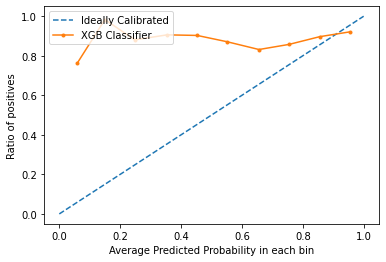

In [ ]:
# Predict Probabilities
prob = best_model.predict_proba(X)
 
# Creating Calibration Curve
x, y = calibration_curve(T, prob[np.arange(prob.shape[0]), T.values], n_bins = 10, normalize = True)
 
# Plot calibration curve
 
# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve
plt.plot(y, x, marker = '.', label = 'XGB Classifier')
 
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

### check overlap

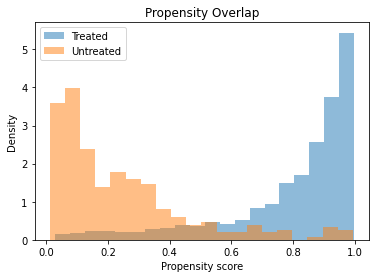

In [27]:
propensity_score = best_model_ps.predict_proba(X)[:, 1]
# print(propensity_score)
treatment = T.values
# print(treatment)

mean_ps_treated = np.mean(propensity_score[treatment == 1])
mean_ps_untreated = np.mean(propensity_score[treatment == 0])

# print(mean_ps_treated, mean_ps_untreated)

plt.hist(propensity_score[treatment == 1], density=True, alpha=0.5, bins=20, label='Treated')
plt.hist(propensity_score[treatment == 0], density=True, alpha=0.5, bins=20, label='Untreated')
# plt.axvline(mean_ps_treated, color='blue', linestyle='--', label='Mean PS (treated)')
# plt.axvline(mean_ps_untreated, color='orange', linestyle='--', label='Mean PS (untreated)')
plt.legend()
plt.title("Propensity Overlap")
plt.xlabel('Propensity score')
plt.ylabel('Density')
plt.show()

In [34]:
print(np.histogram(propensity_score[treatment == 0], bins=20))
print(np.histogram(propensity_score[treatment == 1], bins=20))
# np.sort(propensity_score[treatment == 0])

(array([54, 60, 36, 21, 27, 24, 22, 12,  9,  6,  7,  3,  3,  6,  3,  4,  0,
        1,  5,  4]), array([0.01201959, 0.06108773, 0.11015587, 0.159224  , 0.20829214,
       0.25736028, 0.3064284 , 0.35549656, 0.40456468, 0.45363283,
       0.502701  , 0.5517691 , 0.60083723, 0.6499054 , 0.69897354,
       0.7480416 , 0.7971098 , 0.84617794, 0.8952461 , 0.9443142 ,
       0.99338233], dtype=float32))
(array([ 19,  23,  29,  31,  27,  25,  36,  40,  50,  48,  60,  55,  69,
       107, 121, 193, 220, 334, 487, 704]), array([0.03049301, 0.07884018, 0.12718736, 0.17553453, 0.22388169,
       0.27222887, 0.32057604, 0.36892322, 0.4172704 , 0.46561757,
       0.5139647 , 0.5623119 , 0.61065906, 0.65900624, 0.7073534 ,
       0.7557006 , 0.80404776, 0.85239494, 0.9007421 , 0.9490893 ,
       0.99743646], dtype=float32))


### Trim extreme propensity scores

In [28]:
X_new = []
T_new = []
Y_new = []
propensity_score_new = []

for i, ps in enumerate(propensity_score):
  if ps < 0.8 and ps > 0.11:
    X_new.append(X.values[i])
    T_new.append(T.values[i])
    Y_new.append(Y.values[i])
    propensity_score_new.append(ps)

X_new = pd.DataFrame(data=X_new, columns=X.columns)
T_new = pd.Series(data=T_new, name='T')
Y_new = pd.Series(data=Y_new, name='HUMRAT_TEUNA')
propensity_score_new = pd.Series(data=propensity_score_new, name='propensity score')

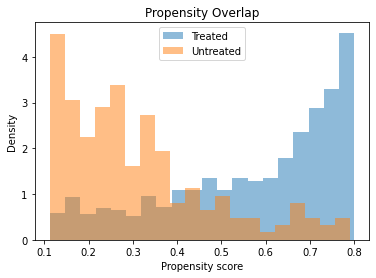

In [29]:
treatment = T_new.values


plt.hist(propensity_score_new[treatment == 1], density=True, alpha=0.5, bins=20, label='Treated')
plt.hist(propensity_score_new[treatment == 0], density=True, alpha=0.5, bins=20, label='Untreated')
# plt.axvline(mean_ps_treated, color='blue', linestyle='--', label='Mean PS (treated)')
# plt.axvline(mean_ps_untreated, color='orange', linestyle='--', label='Mean PS (untreated)')
plt.legend()
plt.title("Propensity Overlap")
plt.xlabel('Propensity score')
plt.ylabel('Density')
plt.show()

In [32]:
np.unique(T_new, return_counts=True), np.unique(Y_new, return_counts=True)

((array([0, 1]), array([183, 881])),
 (array([1, 2, 3]), array([ 48, 198, 818])))

## Estimate ATE

change Y values from {1,2,3} to {0,1,2} by subtracting 1

In [30]:
Y_new = Y_new - 1

### S-Learner
Use 1 model to estimate Y with X,T as features

$y ≈ f(x,t)$

$\widehat{ATE}$ = $1 \over n$ $\sum f(x_i,1) - f(x_i,0)$

In [31]:
# concatenate X and T
cov = X_new.join([T_new])
cov_train, cov_test, y_train, y_test = train_test_split(cov, Y_new, random_state=27)

In [41]:
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'eta': [0.2, 0.1, 0.05],
    'n_estimators': np.arange(50, 301, 50)
}
best_params_s, best_score_s, best_model_s = xgb_classifier_tuning(cov_train, y_train, param_grid, multi_class=True)

[07:45:32] WARNING: ../src/learner.cc:767: 
Parameters: { "weight" } are not used.

Best hyperparameters found:
 {'eta': 0.2, 'max_depth': 6, 'n_estimators': 50}
Best score: 0.7169846192672275


In [42]:
best_model_s.save_model("xgb_s_learner_model.json")

# best_model_s = xgb.XGBClassifier()
# best_model_s.load_model("xgb_s_learner_model.json")

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:761: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(


In [43]:
y_pred = best_model_s.predict(cov_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[  1   3  13]
 [  1   7  40]
 [  0  16 185]]
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        17
           1       0.27      0.15      0.19        48
           2       0.78      0.92      0.84       201

    accuracy                           0.73       266
   macro avg       0.52      0.38      0.38       266
weighted avg       0.67      0.73      0.68       266



In [44]:
print(confusion_matrix(Y_new, best_model_s.predict(cov)))
print(classification_report(Y_new, best_model_s.predict(cov)))

[[ 32   3  13]
 [  1 155  42]
 [  0  16 802]]
              precision    recall  f1-score   support

           0       0.97      0.67      0.79        48
           1       0.89      0.78      0.83       198
           2       0.94      0.98      0.96       818

    accuracy                           0.93      1064
   macro avg       0.93      0.81      0.86      1064
weighted avg       0.93      0.93      0.93      1064



s-learner ATE

In [45]:
cov_t0 = cov.copy()
cov_t0['T'] = 0

cov_t1 = cov.copy()
cov_t1['T'] = 1

ATE_s = (best_model_s.predict(cov_t1) - best_model_s.predict(cov_t0)).mean()
ATE_s

0.03289473684210526

In [72]:
cov.shape

(1064, 39)

### T-Learner
fit 2 models, one for each treatment type (use only X as features)
$Y_0 ≈ f_0(x), Y_1 ≈ f_1(x)$

$\widehat{ATE}$ = $1 \over n$ $\sum f_1(x_i) - f_0(x_i)$

In [32]:
# add Y column to the data to ease the split
data = cov.join([Y_new])

In [34]:
data.to_csv('data.csv')

In [47]:
X_0 = data[data['T'] == 0].copy().drop(['T', 'HUMRAT_TEUNA'], axis=1)
X_1 = data[data['T'] == 1].copy().drop(['T', 'HUMRAT_TEUNA'], axis=1)

Y_0 = data[data['T'] == 0]['HUMRAT_TEUNA'].copy()
Y_1 = data[data['T'] == 1]['HUMRAT_TEUNA'].copy()
X_0.shape, X_1.shape, Y_0.shape, Y_1.shape

((183, 38), (881, 38), (183,), (881,))

In [48]:
X0_train, X0_test, y0_train, y0_test = train_test_split(X_0, Y_0, random_state=27)
X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, Y_1, random_state=27)

In [49]:
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'eta': [0.2, 0.1, 0.05],
    'n_estimators': np.arange(50, 301, 50)
}
best_params_0, best_score_0, best_model_0 = xgb_classifier_tuning(X0_train, y0_train, param_grid, multi_class=True)
best_params_1, best_score_1, best_model_1 = xgb_classifier_tuning(X1_train, y1_train, param_grid, multi_class=True)

[07:48:16] WARNING: ../src/learner.cc:767: 
Parameters: { "weight" } are not used.

Best hyperparameters found:
 {'eta': 0.2, 'max_depth': 4, 'n_estimators': 150}
Best score: 0.6581875862770172
[07:51:56] WARNING: ../src/learner.cc:767: 
Parameters: { "weight" } are not used.

Best hyperparameters found:
 {'eta': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best score: 0.7280332239637043


In [50]:
print(confusion_matrix(Y_0, best_model_0.predict(X_0)))
print(classification_report(Y_0, best_model_0.predict(X_0)))

print(confusion_matrix(Y_1, best_model_1.predict(X_1)))
print(classification_report(Y_1, best_model_1.predict(X_1)))

[[ 13   0   5]
 [  1  30   9]
 [  2   4 119]]
              precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.88      0.75      0.81        40
           2       0.89      0.95      0.92       125

    accuracy                           0.89       183
   macro avg       0.86      0.81      0.83       183
weighted avg       0.88      0.89      0.88       183

[[ 21   4   5]
 [  0 126  32]
 [  0  11 682]]
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.89      0.80      0.84       158
           2       0.95      0.98      0.97       693

    accuracy                           0.94       881
   macro avg       0.95      0.83      0.88       881
weighted avg       0.94      0.94      0.94       881



calculate t-learner ATE

In [51]:
ate_t = (best_model_1.predict(X_new) - best_model_0.predict(X_new)).mean()
ate_t

0.08740601503759399

### IPW

use the propensity score calculated earlier, mark as $e(x)$.

$\widehat{ATE}$ = $\frac{1}{n} \sum \frac{t_i y_i}{e(x_i)} - \frac{1}{n} \sum \frac{(1-t_i) y_i}{1-e(x_i)}$

In [52]:
ate_ipw = (T_new * Y_new / propensity_score_new).mean() - ((1-T_new) * Y_new / (1 - propensity_score_new)).mean()
ate_ipw

2.652950244831529

## Bootstraping for ATE estimation

1. sample (with replacement) from the data
2. refit a model
3. calculate ate

In [101]:
def bootstrap(data, num_iter):
  print("Started at: ", datetime.now().strftime("%H:%M:%S"))
  ATE = {
      's': [],
      't': [],
      'ipw': []
  }

  for i in range(num_iter):
    sample = data.sample(data.shape[0], replace=True)
    X_sample = sample.drop(['T', 'HUMRAT_TEUNA'], axis=1)
    T_sample = sample['T']
    Y_sample = sample['HUMRAT_TEUNA']



    # S-learner. X includes T in this model
    X_s = sample.copy().drop(['HUMRAT_TEUNA'], axis=1)
    Y_s = sample['HUMRAT_TEUNA']
    X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, Y_s, random_state=27)
    best_params_s, best_score_s, best_model_s = xgb_classifier_tuning(
        X_s_train, y_s_train, param_grid, multi_class=True)
    X_t0 = X_s.copy()
    X_t0['T'] = 0

    X_t1 = X_s.copy()
    X_t1['T'] = 1

    ATE['s'].append((best_model_s.predict(X_t1) - best_model_s.predict(X_t0)).mean())


    # T-Learner
    X_t_0 = sample[sample['T'] == 0].copy().drop(['T', 'HUMRAT_TEUNA'], axis=1)
    X_t_1 = sample[sample['T'] == 1].copy().drop(['T', 'HUMRAT_TEUNA'], axis=1)

    Y_t_0 = sample[sample['T'] == 0]['HUMRAT_TEUNA'].copy()
    Y_t_1 = sample[sample['T'] == 1]['HUMRAT_TEUNA'].copy()

    Xt0_train, Xt0_test, yt0_train, yt0_test = train_test_split(X_t_0, Y_t_0, random_state=27)
    Xt1_train, Xt1_test, yt1_train, yt1_test = train_test_split(X_t_1, Y_t_1, random_state=27)

    best_params_0, best_score_0, best_model_0 = xgb_classifier_tuning(
        Xt0_train, yt0_train, param_grid, multi_class=True)
    best_params_1, best_score_1, best_model_1 = xgb_classifier_tuning(
        Xt1_train, yt1_train, param_grid, multi_class=True)

    ATE['t'].append((best_model_1.predict(X_sample) - best_model_0.predict(X_sample)).mean())


    # IPW
    X_ipw_train, X_ipw_test, T_ipw_train, T_ipw_test = train_test_split(X_sample, T_sample, random_state=27)
    best_params_ps, best_score_ps, best_model_ps = xgb_classifier_tuning(
        X_ipw_train, T_ipw_train, param_grid, multi_class=False)

    e_x = best_model_ps.predict_proba(X_sample)[:, 1]

    ATE['ipw'].append((T_sample * Y_sample / e_x).mean() - ((1-T_sample) * Y_sample / (1 - e_x)).mean())

    if i+1 % 10 == 0:
      pd.DataFrame(data=ATE).to_csv('bootstrap_ate.csv')
    
    print(f"Iteration {i+1} ended at ", datetime.now().strftime("%H:%M:%S"))


  return ATE

In [ ]:
# ate = bootstrap(data, 50)

### Results of bootstrap process

In [7]:
ate_df = pd.read_csv('bootstrap_ate_300.csv', index_col=0)

In [8]:
ate_df.describe()

,s,t,ipw
count,300.000000,300.000000,300.000000
mean,0.024264,0.073578,-1.165559
std,0.020382,0.068188,4.467346
min,-0.003759,-0.074248,-34.976060
25%,0.011043,0.024436,-1.172374
50%,0.019737,0.072838,0.417341
75%,0.031955,0.116071,1.034225
max,0.152256,0.272556,1.767357


In [46]:

def get_conf_int(arr, alpha):
  L = np.quantile(arr, alpha/2)
  U = np.quantile(arr, 1-alpha/2)
  return round(L, 4), round(U, 4)

In [45]:
alpha = 0.05
CI = [(x, ate_df[x].mean(), get_conf_int(ate_df[x], alpha)) for x in ate_df.columns]
CI

[('s', 0.024263784461152852, (0.0, 0.072)),
 ('t', 0.07357769423558895, (-0.0495, 0.2266)),
 ('ipw', -1.165558944635343, (-15.3755, 1.5767))]

In [39]:
ci_df = pd.DataFrame(data=CI, columns=['method', 'mean', '95% CI'])
ci_df.set_index(list(ci_df)[0])

,mean,95% CI
method,,
s,0.024264,"(0.0, 0.018796992481203)"
t,0.073578,"(-0.04945958646616536, 0.0686325187969924)"
ipw,-1.165559,"(-15.375458150030513, 0.23425957262830147)"
